# Shock Tube

> WORK IN PROGRESS !!!

In this example we are going to solve the Euler equations for a one-dimensional shock tube.

\begin{equation}
    \begin{array}{c}
        \rho_t + (\rho u)_x = 0 \\
        (\rho u)_t + (\rho u u + p)_x = 0 \\
        (\rho e)_t + (u ( \rho e + p ))_x = 0 \\
    \end{array}
\end{equation}

The inputs to the network will be the independent variables $x$ and $t$ and the outputs will be the density, $\rho$, the velocity $u$ and the pressure $p$. We can compute the internal energy with the expression $\rho e = 0.5 \rho u u + p/(\gamma-1)$ with $\gamma=1.4$ for air.

![](https://i1.wp.com/curiosityfluids.com/wp-content/uploads/2016/07/shocktube.gif?fit=600%2C259&ssl=1)

In [ ]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# imports
import math
import numpy as np 
import matplotlib.pyplot as plt 

import torch
cuda = True
device = "cuda" if torch.cuda.is_available() and cuda else "cpu"

## Define PDE

First we define our PDE and set the values for training.

In [ ]:
# imports
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco

# define our PDE
class MyPDE(PDE):
    def __init__(self, inputs, outputs, params):
        super().__init__(inputs, outputs, params)
    # the loss of our NN is the PDE !
    def computePDELoss(self, grads, inputs, outputs, params): 
        drdt = grads['r']['t']        
        r, u, p = outputs['r'], outputs['u'], outputs['p']
        ru = r*u
        drudx = self.computeGrad(ru, 'x')
        drudt = self.computeGrad(ru, 't')
        ruup = r*u*u + p
        druupdx =  self.computeGrad(ruup, 'x')
        re = p/(params['g']-1) + 0.5*r*u*u
        dredt = self.computeGrad(re, 't')
        repu = (re+p)*u
        drepudx = self.computeGrad(repu, 'x')
        return [
            drdt + drudx,
            drudt + druupdx,
            dredt + drepudx 
        ]

# instanciate pde with keys for inputs/outputs
pde = MyPDE(inputs=['x', 't'], outputs=['r', 'u', 'p'], params=['g'])

# define input values for training
x = np.linspace(0,1,50)
t = np.linspace(0,1,33)
g = 1.4

pde.setValues({'x': x, 't': t, 'g': np.array([g])})

# define input values for validation
x_v = np.linspace(0,1,25)
t_v = np.linspace(0,1,15)
pde.setValues({'x': x_v, 't': t_v}, train=False)

In [ ]:
# initial condition (dirichlet for temporal dimension)
rl, pl, rr, pr = 10, 10/g, 1, 1/g

r0 = np.zeros(len(x))
u0 = np.zeros(len(x))
p0 = np.zeros(len(x))
for i, _x in enumerate(x):
    u0[i] = 0.
    if _x < 0.5:
        r0[i] = rl
        p0[i] = pl
    else:
        r0[i] = rr
        p0[i] = pr
    
boco = DirichletBoco('initial_condition', {'x': x, 't': np.array([0])}, {'r': r0, 'u': u0, 'p': p0})
pde.addBoco(boco)

# dirichlet b.c for the space dimension
x1, x2 = np.array([0]), np.array([1])
ones = np.ones(len(t))
boco = DirichletBoco('boco_left', {'x': x1, 't': t}, {'r': r0[0]*ones, 'u': u0[0]*ones, 'p': p0[0]*ones})
pde.addBoco(boco)
boco = DirichletBoco('boco_rigth', {'x': x2, 't': t}, {'r': r0[len(x)-1]*ones, 'u': u0[len(x)-1]*ones, 'p': p0[len(x)-1]*ones})
pde.addBoco(boco)

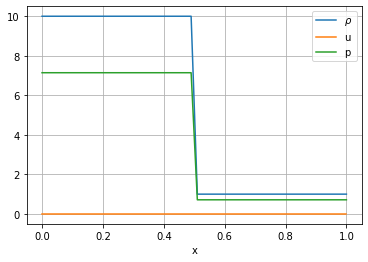

In [ ]:
# visualize initial condition

plt.plot(x, r0)
plt.plot(x, u0)
plt.plot(x, p0)
plt.legend(['$\\rho$', 'u', 'p'])
plt.grid()
plt.xlabel('x')
plt.show()

Now we define a topology for our solution and set the training parameters. Then we can find a solution for our PDE.

In [ ]:
# define solution topology
topo = {'layers': 5, 'neurons': 2048, 'activations': 'relu'}
pde.buildSolution(topo)

# set optimization parameters
pde.compile(epochs=100)


In [ ]:
# find the solution
hist = pde.solve(device, 'st_best.pth') 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(hist['train_loss'], label="train_loss")
ax1.plot(hist['val_loss'], label="val_loss")
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
for boco in pde.bocos:
    ax2.plot(hist['bocos'][boco.name], label=boco.name)
ax2.legend()
ax2.grid(True)
ax2.set_yscale("log")
plt.show()

Finally, we can evaluate our solution.

In [ ]:
# evaluate the solution
pde.load_state_dict('st_best.pth')
x = np.linspace(0,1,50)
t = np.linspace(0,1,20)
r, u, p = [], [], []
for _t in t:
    pde.evaluate({'x': x, 't': np.array([0])}, device)
    r.append(pde.outputs['r'])
    u.append(pde.outputs['u'])
    p.append(pde.outputs['p'])

from matplotlib import animation, rc
rc('animation', html='html5')

def plot(x, r, u, p, t):
    ax.clear()
    tit = ax.set_title(f"t = {t:.2f}", fontsize=14)
    ax.plot(x, r, label="$\\rho$")
    ax.plot(x, u, label="u")
    ax.plot(x, p, label="p")
    ax.set_xlabel("x", fontsize=14)
    ax.legend(loc="upper right")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.2, 10.2])
    return [tit]

def get_anim(fig, ax, x, r, u, p, t):
    def anim(i):
        return plot(x, r[i], u[i], p[i], t[i])
    return anim

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, x, r, u, p, t)
anim = animation.FuncAnimation(fig, animate, frames=len(t), interval=100, blit=True)

In [ ]:
anim